In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## Data preprocessing

In [109]:
df = pd.read_csv('./train.csv')
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [110]:
enc_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
               'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
               'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
               'SaleType','SaleCondition']
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [111]:
real_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'MiscVal','MoSold','YrSold']
cat_features = list(set(df.columns.values.tolist()) - set(real_features))
cat_features.remove('SalePrice')
print (real_features)
print (cat_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['Neighborhood_IDOTRR', 'BsmtFinType2_LwQ', 'Functional_Sev', 'Exterior1st_MetalSd', 'LandSlope_Gtl', 'MSSubClass_75', 'LotShape_Reg', 'ExterCond_Po', 'LotConfig_FR3', 'HouseStyle_2.5Unf', 'Exterior2nd_ImStucc', 'Exterior2nd_Wd Shng', 'HeatingQC_Ex', 'HouseStyle_SFoyer', 'RoofMatl_WdShake', 'Functional_Maj1', 'OverallQual_10', 'Neighborhood_Blmngtn', 'MSZoning_RL', 'Exterior2nd_Stucco', 'GarageFinish_Unf', 'MSZoning_RM', 'RoofMatl_CompShg', 'Condition2_Feedr', 'BsmtCond_Fa', 'Functional_Maj2', 'Neighborhood_Mitchel', 'BsmtQual_TA', 'Condition1_PosA', 

In [112]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [113]:
df[cat_features].describe()

,Neighborhood_IDOTRR,BsmtFinType2_LwQ,Functional_Sev,Exterior1st_MetalSd,LandSlope_Gtl,MSSubClass_75,LotShape_Reg,ExterCond_Po,LotConfig_FR3,HouseStyle_2.5Unf,...,SaleCondition_Family,GarageQual_Gd,Exterior1st_ImStucc,Neighborhood_Edwards,Condition2_Norm,OverallQual_6,BsmtFinType1_Unf,SaleType_Con,RoofStyle_Mansard,Condition1_RRAn
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.025342,0.031507,0.000685,0.150685,0.946575,0.010959,0.633562,0.000685,0.002740,0.007534,...,0.013699,0.009589,0.000685,0.068493,0.989726,0.256164,0.294521,0.001370,0.004795,0.017808
std,0.157217,0.174743,0.026171,0.357864,0.224956,0.104145,0.481996,0.026171,0.052289,0.086502,...,0.116277,0.097486,0.026171,0.252677,0.100873,0.436663,0.455983,0.036999,0.069100,0.132299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
print (df.shape)

(1460, 320)


In [115]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0)    

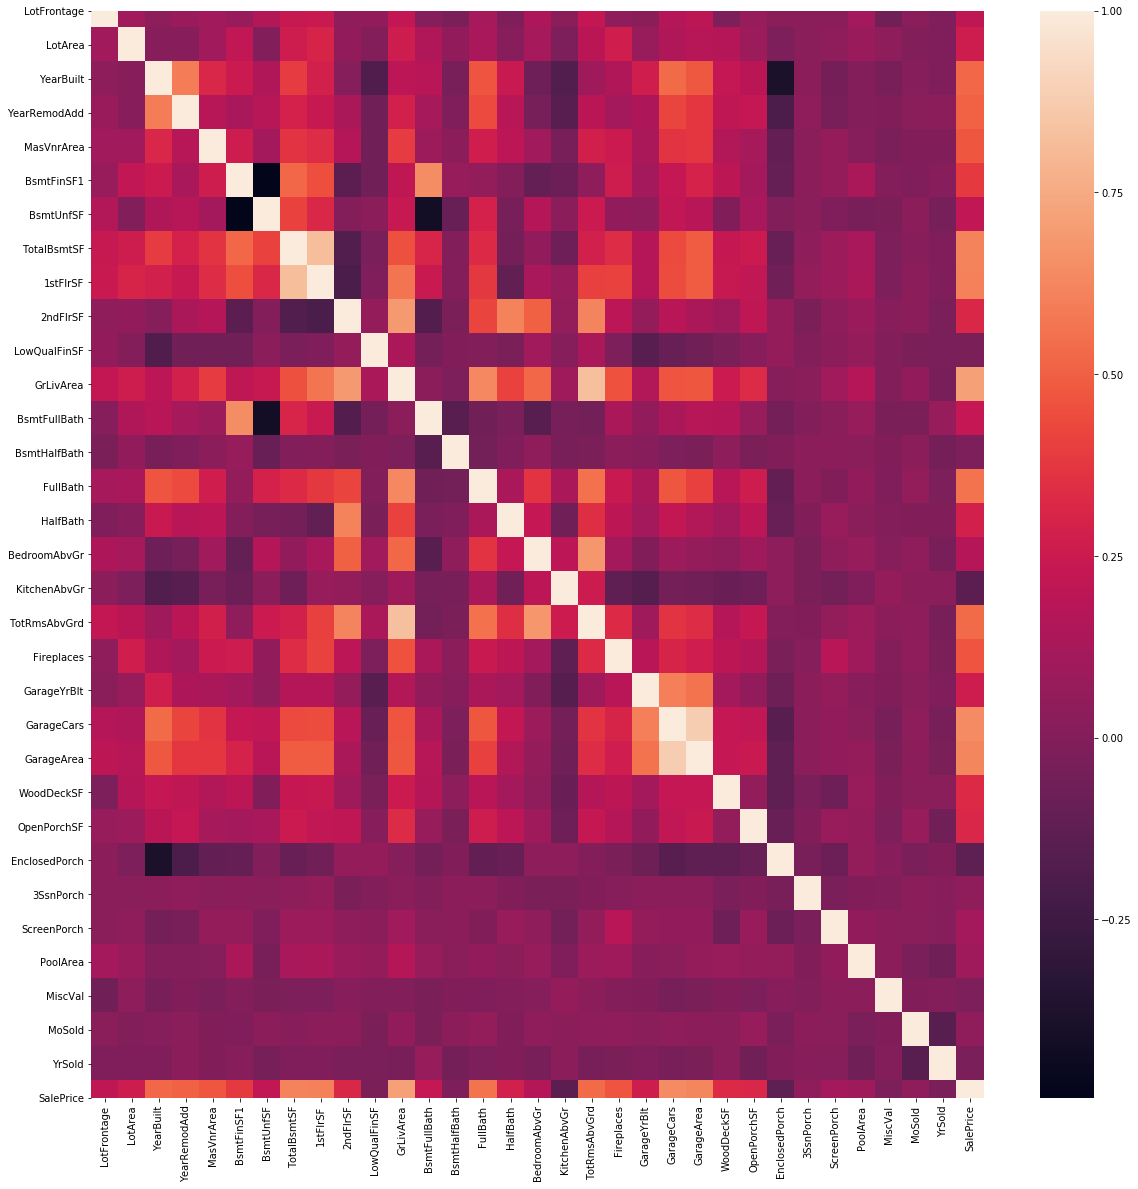

In [116]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[real_features + ['SalePrice']].corr())

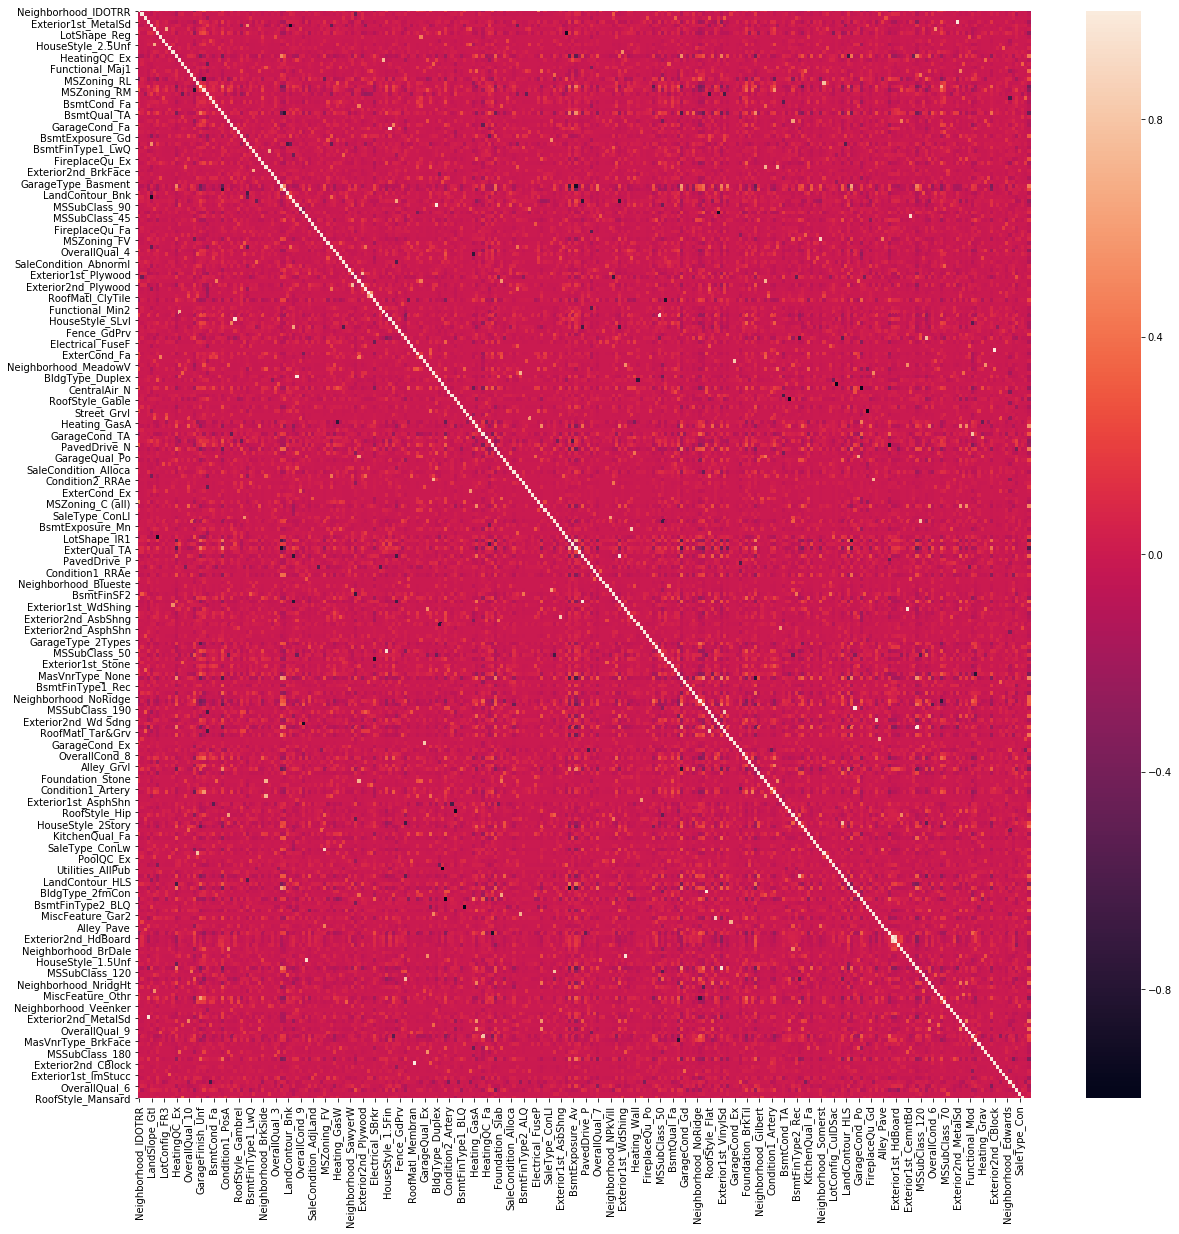

In [117]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[cat_features + ['SalePrice']].corr())

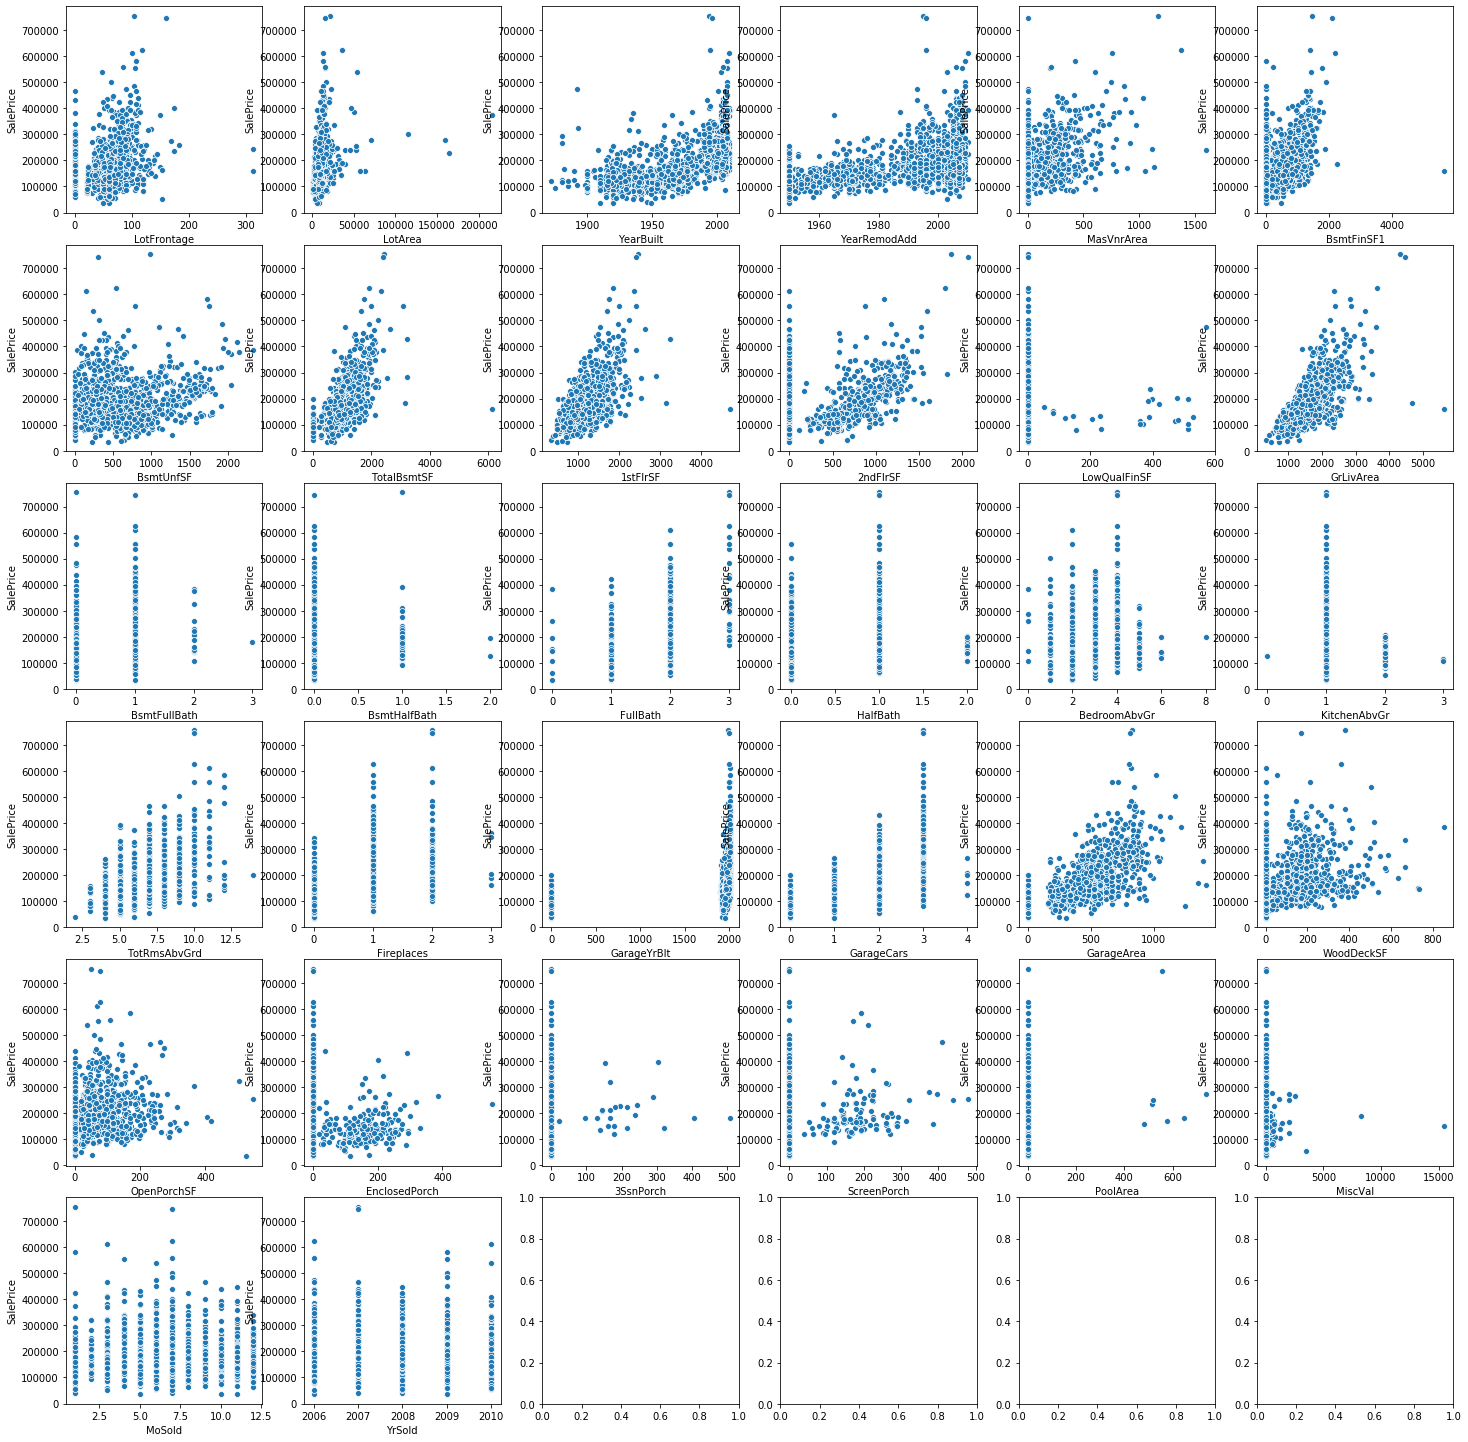

In [118]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
fig.tight_layout()
ax = iter(ax.flatten())
for feat in real_features:
    sns.scatterplot(x=feat, y='SalePrice', data=df, ax=next(ax))

In [119]:
y = df['SalePrice'].to_numpy()
df = df.drop('SalePrice', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [6.500e+01 8.450e+03 2.003e+03 2.003e+03 1.960e+02 7.060e+02 1.500e+02
 8.560e+02 8.560e+02 8.540e+02 0.000e+00 1.710e+03 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 1.000e+00 8.000e+00 0.000e+00 2.003e+03
 2.000e+00 5.480e+02 0.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 2.008e+03] 
X_cat: [0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] 
y: 208500 


### Polynomial features

In [120]:
transform = PolynomialFeatures(2)
X_poly_real = transform.fit_transform(X_real)

In [121]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_poly_real)

In [122]:
print (X_real_scaled.shape)
print (X_cat.shape)
print (y.shape)

(1460, 561)
(1460, 287)
(1460,)


### Checking dataset

In [123]:
#(X_train_real, X_test_real, X_train_cat, X_test_cat, 
# y_train, y_test) = train_test_split(X_real_scaled, X_cat, y, test_size=0.3, random_state=0)
#print (X_train_real.shape, X_test_real.shape)
#print (X_train_cat.shape, X_test_cat.shape)

#print (y_train.shape, y_test.shape)

In [124]:
#X_train = np.hstack((X_train_real, X_train_cat))
#X_test = np.hstack((X_test_real, X_test_cat))
X = np.hstack((X_real_scaled, X_cat))

In [125]:
xi = np.isfinite(X) 
print (xi[np.where(xi == False)].sum())

xn = np.isnan(X) 
print (xn[np.where(xn == False)].sum())

0
0


In [126]:
yi = np.isfinite(y) 
print (yi[np.where(yi == False)].sum())

yn = np.isnan(y) 
print (yn[np.where(yn == False)].sum())

0
0


## Features selection with Lasso

In [127]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [128]:
param_grid = {
    'alpha': [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0], 'max_iter': [100000]
}
estimator = Lasso()

ls_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
ls_model.fit(X, y)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
print (ls_model.best_estimator_)

In [ ]:
print (ls_model.best_score_)

In [ ]:
c = 0
not_null_idx = []
for cf in optimizer.best_estimator_.coef_:
    if cf != 0:
        not_null_idx.append(c)
    c += 1
print (len(not_null_idx))    
print (not_null_idx)    

In [ ]:
X = X[:, not_null_idx]
print (X.shape)

## Linear regression

### Ridge

In [24]:
rg_model = Ridge(alpha=.5)

score = cross_val_score(rg_model, X, y, cv=10)
score_mean = score.mean()

In [25]:
print (score_mean)

0.8702742637818044


In [26]:
score = cross_val_score(rg_model, X, y, cv=5)
score_mean = score.mean()

In [27]:
print (score_mean)

0.8649352990964114


In [28]:
param_grid = {
    'alpha': [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 20, 30]
}
estimator = Ridge()

rg2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rg2_model.fit(X, y)

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    5.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.02, 0.05, 0.07, 0.08, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 20,
                                   30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [29]:
print (rg2_model.best_estimator_)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)


In [30]:
print (rg2_model.best_score_)

0.8721590366304683


### ElasticNet

In [31]:
el_model = ElasticNet(alpha=.5, l1_ratio=.5, max_iter=100000)

score = cross_val_score(el_model, X, y, cv=10)
score_mean = score.mean()

In [32]:
print (score_mean)

0.8014276584948149


In [33]:
score = cross_val_score(el_model, X, y, cv=5)
score_mean = score.mean()

In [34]:
print (score_mean)

0.786034229476


In [35]:
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1., 5., 10., 20., 30.],               
              'l1_ratio': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
              'max_iter': [100000]}
estimator = ElasticNet()

el2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
el2_model.fit(X, y)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  3.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 5.0, 10.0],
                         'l1_ratio': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                         'max_iter': [100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [36]:
print (el2_model.best_estimator_)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [37]:
print (el2_model.best_score_)

0.8522078607953527


### LassoLars

In [38]:
la_model = LassoLars(alpha=.5, max_iter=30)

score = cross_val_score(la_model, X, y, cv=10)
score_mean = score.mean()

In [39]:
print (score_mean)

0.7792525605399935


In [40]:
score = cross_val_score(la_model, X, y, cv=5)
score_mean = score.mean()

In [41]:
print (score_mean)

0.7743216322023164


In [42]:
param_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 5., 10.], 'max_iter': [30, 20]
}
estimator = LassoLars(max_iter=30)

la2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
la2_model.fit(X, y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.0s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LassoLars(alpha=1.0, copy_X=True,
                                 eps=2.220446049250313e-16, fit_intercept=True,
                                 fit_path=True, max_iter=30, normalize=True,
                                 positive=False, precompute='auto',
                                 verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 5.0, 10.0],
                         'max_iter': [30, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [43]:
print (la2_model.best_estimator_)

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=30, normalize=True, positive=False,
          precompute='auto', verbose=False)


In [44]:
print (la2_model.best_score_)

0.7792525605399938


## Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
rf_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

score = cross_val_score(rf_model, X, y, cv=10)
score_mean = score.mean()

In [47]:
print (score_mean)

0.8133460856362102


In [48]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700], 'max_depth': [2, 3, 4, 5, 10]
}
estimator = RandomForestRegressor()

rf2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rf2_model.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 10.3min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 10],
 

In [49]:
print (rf2_model.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [50]:
print (rf2_model.best_score_)


0.8490997404448096


## XGBoost

In [51]:
from xgboost import XGBRegressor

In [52]:
xgb_model = XGBRegressor()

score = cross_val_score(xgb_model, X, y, cv=10)
score_mean = score.mean()

[09:26:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [53]:
print (score_mean)

0.8713314613095932


In [54]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3],
    'gamma': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'n_estimators': [100, 200, 300, 400, 500]
}
estimator = XGBRegressor()

xgb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
xgb2_model.fit(X, y)

Fitting 10 folds for each of 810 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed: 67.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | e

[10:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'gamma': [0.1, 0.2, 0.3],
                         'learning_rate': [0.05, 0.1, 0.2],
           

In [55]:
print (xgb2_model.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=4, min_child_weight=2, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [56]:
print (xgb2_model.best_score_)

0.8873312472022326


## Voting

In [57]:
from sklearn.ensemble import VotingRegressor

In [90]:
vt_model = VotingRegressor([
    ('rg', rg2_model.best_estimator_),    
    ('gb', xgb2_model.best_estimator_),
    ('el', el2_model.best_estimator_), 
    ('rf', rf2_model.best_estimator_)
], n_jobs=-1)

print (vt_model)

VotingRegressor(estimators=[('rg',
                             Ridge(alpha=1, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('gb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.4, gamma=0.1,
                                          importance_type='gain',
                                          learning_rate=0.2, max_delta_step=0,
                                          max_depth=4, min_ch...
                                        tol=0.0001, warm_start=False)),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
         

In [91]:
score = cross_val_score(vt_model, X, y, cv=10)
score_mean = score.mean()

In [92]:
print (score_mean)

0.8896097327340847


In [93]:
vt_model.fit(X, y)

VotingRegressor(estimators=[('rg',
                             Ridge(alpha=1, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('gb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.4, gamma=0.1,
                                          importance_type='gain',
                                          learning_rate=0.2, max_delta_step=0,
                                          max_depth=4, min_ch...
                                        tol=0.0001, warm_start=False)),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
         

In [94]:
print (len(vt_model.estimators))

4


### LR submission

In [72]:
df_train = df.copy()

df = pd.read_csv('./test.csv')
house_ids = df['Id'].to_numpy()
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [73]:
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,1961,1961,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,1,0,0,0,0,1,0
1,81.0,14267,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,...,0,0,0,1,0,0,0,0,1,0
2,74.0,13830,1997,1998,0.0,791.0,0.0,137.0,928.0,928,...,0,0,0,1,0,0,0,0,1,0
3,78.0,9978,1998,1998,20.0,602.0,0.0,324.0,926.0,926,...,0,0,0,1,0,0,0,0,1,0
4,43.0,5005,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,...,0,0,0,1,0,0,0,0,1,0


In [74]:
features_diff = list(set(df_train.columns.values.tolist()) - set(df.columns.values.tolist()))
print (len(features_diff), features_diff)
zeros = np.zeros(df.shape[0])

for ft in features_diff:
    df[ft] = pd.Series(zeros)

18 ['RoofMatl_Roll', 'Condition2_RRNn', 'PoolQC_Fa', 'Condition2_RRAe', 'RoofMatl_ClyTile', 'Heating_Floor', 'Condition2_RRAn', 'Heating_OthW', 'Exterior2nd_Other', 'Exterior1st_Stone', 'Electrical_Mix', 'MiscFeature_TenC', 'HouseStyle_2.5Fin', 'RoofMatl_Metal', 'Exterior1st_ImStucc', 'Utilities_NoSeWa', 'RoofMatl_Membran', 'GarageQual_Ex']


In [75]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1232.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,68.580357,9819.161069,1971.357779,1983.662783,100.709141,439.203704,554.294925,1046.117970,1156.534613,325.967786,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,22.376841,4955.517327,30.390071,21.130467,177.625900,455.268042,437.260486,442.898624,398.165820,420.610226,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,21.000000,1470.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,58.000000,7391.000000,1953.000000,1963.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,67.000000,9399.000000,1973.000000,1992.000000,0.000000,350.500000,460.000000,988.000000,1079.000000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11517.500000,2001.000000,2004.000000,164.000000,753.500000,797.750000,1305.000000,1382.500000,676.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,200.000000,56600.000000,2010.000000,2010.000000,1290.000000,4010.000000,2140.000000,5095.000000,5095.000000,1862.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [76]:
df[cat_features].describe()

,Neighborhood_IDOTRR,BsmtFinType2_LwQ,Functional_Sev,Exterior1st_MetalSd,LandSlope_Gtl,MSSubClass_75,LotShape_Reg,ExterCond_Po,LotConfig_FR3,HouseStyle_2.5Unf,...,SaleCondition_Family,GarageQual_Gd,Exterior1st_ImStucc,Neighborhood_Edwards,Condition2_Norm,OverallQual_6,BsmtFinType1_Unf,SaleType_Con,RoofStyle_Mansard,Condition1_RRAn
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000
mean,0.038382,0.028101,0.000685,0.157642,0.956820,0.004798,0.640164,0.001371,0.006854,0.008910,...,0.017820,0.006854,0.0,0.064428,0.989719,0.244688,0.288554,0.002056,0.002742,0.01645
std,0.192184,0.165319,0.026180,0.364530,0.203332,0.069124,0.480117,0.037012,0.082533,0.094005,...,0.132344,0.082533,0.0,0.245597,0.100907,0.430050,0.453245,0.045314,0.052306,0.12724
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [77]:
print (df.shape)

(1459, 320)


In [78]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0) 

In [79]:
X_testing_real = df[real_features].to_numpy()
X_testing_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_testing_real[0]))
print ("X_cat: {} ".format(X_testing_cat[0]))

X_real: [8.0000e+01 1.1622e+04 1.9610e+03 1.9610e+03 0.0000e+00 4.6800e+02
 2.7000e+02 8.8200e+02 8.9600e+02 0.0000e+00 0.0000e+00 8.9600e+02
 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00
 5.0000e+00 0.0000e+00 1.9610e+03 1.0000e+00 7.3000e+02 1.4000e+02
 0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+02 0.0000e+00 0.0000e+00
 6.0000e+00 2.0100e+03] 
X_cat: [  0.   1.   0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   1.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   1.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [80]:
X_testing_poly_real = transform.fit_transform(X_testing_real)

In [81]:
X_testing_real_scaled = scaler.fit_transform(X_testing_poly_real)

In [85]:
X_testing = np.hstack((X_testing_real_scaled, X_testing_cat))

X_testing = X_testing[:, not_null_idx]
print (X_testing.shape)

(1459, 333)


In [86]:
predicted = vt_model.predict(X_testing)

print (predicted)
print (house_ids)

[110028.1993551  183677.02679542 196937.90851424 ... 178133.94581927
 105857.05939669 211378.25727246]
[1461 1462 1463 ... 2917 2918 2919]


In [87]:
with open("submission_vt2.txt", "w") as fout:
    fout.write("Id,SalePrice\n")
    for val in zip(house_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))